This notebook is for poor version of LSTM!

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'res_lstm/'

In [3]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    df_res = df_res.append(pd.read_csv(os.path.join(data_dir, f)))
df_log = pd.read_csv('res_log_que.csv')    

columns = ['matthews', 'test_matthews', 'stock', 'unit']
print(df_res.columns)
df_best = df_res.sort_values(by='matthews', ascending=False).groupby(['stock']).head(1)
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['_lstm', '_log'])

Index(['Unnamed: 0', 'f1', 'features', 'kappa', 'kernel', 'matthews',
       'precision', 'recall', 'roc_auc', 'stock', 'test_f1', 'test_kappa',
       'test_matthews', 'test_precision', 'test_recall', 'test_roc_auc',
       'train_f1', 'train_kappa', 'train_matthews', 'train_precision',
       'train_recall', 'train_roc_auc', 'unit'],
      dtype='object')


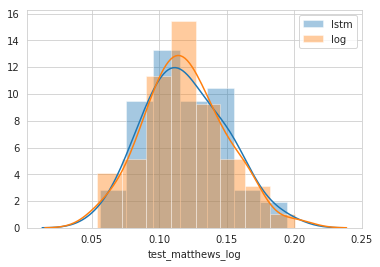

In [4]:
sns.distplot(df_best['test_matthews_lstm'], label='lstm')
sns.distplot(df_best['test_matthews_log'], label='log')
plt.legend()

In [26]:
print(df_best[df_best['test_matthews_lstm'] < df_best['test_matthews_log']]['stock'].values)

[ 8080 11946  3879  1907  1472  1956  1388  1431  9268  9063 10508  4320
  2651  4799 11869  9269  9266 10166  9094  5836  9069  9058 10887  9062]


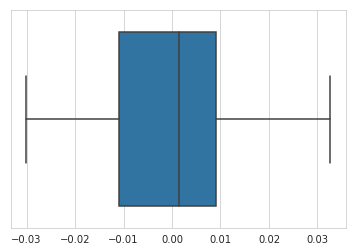

In [15]:
sns.boxplot(df_best['test_matthews_lstm'] - df_best['test_matthews_log'])

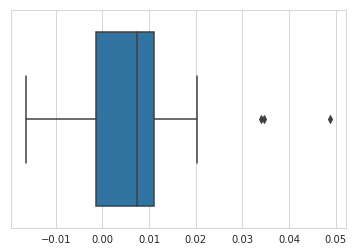

In [14]:
sns.boxplot(df_best['matthews_lstm'] - df_best['matthews_log'])

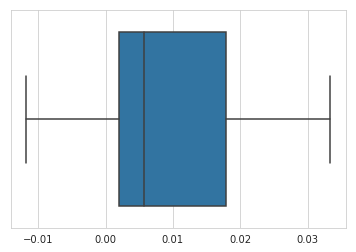

In [16]:
sns.boxplot(df_best['train_matthews_lstm'] - df_best['train_matthews_log'])

In [6]:
df_best.columns

Index(['Unnamed: 0_lstm', 'f1_lstm', 'features', 'kappa_lstm', 'kernel_lstm',
       'matthews_lstm', 'precision_lstm', 'recall_lstm', 'roc_auc_lstm',
       'stock', 'test_f1_lstm', 'test_kappa_lstm', 'test_matthews_lstm',
       'test_precision_lstm', 'test_recall_lstm', 'test_roc_auc_lstm',
       'train_f1_lstm', 'train_kappa_lstm', 'train_matthews_lstm',
       'train_precision_lstm', 'train_recall_lstm', 'train_roc_auc_lstm',
       'unit', 'Unnamed: 0_log', 'f1_log', 'kappa_log', 'kernel_log',
       'matthews_log', 'precision_log', 'recall_log', 'roc_auc_log',
       'test_f1_log', 'test_kappa_log', 'test_matthews_log',
       'test_precision_log', 'test_recall_log', 'test_roc_auc_log',
       'train_f1_log', 'train_kappa_log', 'train_matthews_log',
       'train_precision_log', 'train_recall_log', 'train_roc_auc_log'],
      dtype='object')

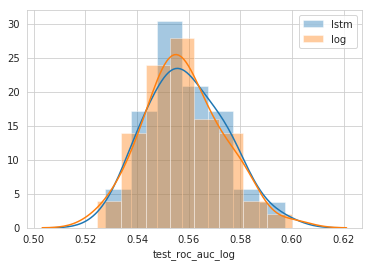

In [7]:
sns.distplot(df_best['test_roc_auc_lstm'], label='lstm')
sns.distplot(df_best['test_roc_auc_log'], label='log')
plt.legend()

In [17]:
print(df_best[df_best['test_roc_auc_lstm'] < df_best['test_roc_auc_log']]['stock'].values)

[ 8080 11946  3879  1907  1472  1956  1388  1431  9268  9063 10508  4320
  2651 10484  4799  9269  9266 10166  9094  5836  9069  9058 10887  9062]


In [23]:
columns = ['stock'] + [c for c in df_best.columns if 'matthews' in c]
df_best[columns]

,stock,matthews_lstm,test_matthews_lstm,train_matthews_lstm,matthews_log,test_matthews_log,train_matthews_log
0,8080,0.204807,0.104528,0.151504,0.194919,0.123613,0.131841
1,11946,0.190839,0.194577,0.189240,0.174051,0.200098,0.187279
2,7858,0.184370,0.180199,0.168613,0.135518,0.167558,0.152379
3,3879,0.178989,0.109215,0.187383,0.174942,0.121287,0.168294
4,13003,0.169189,0.090179,0.135942,0.183702,0.086969,0.135421
5,1907,0.168619,0.125802,0.154027,0.148356,0.147243,0.129991
6,1472,0.167533,0.114930,0.174203,0.147860,0.126008,0.147648
7,1956,0.165954,0.125410,0.167724,0.153455,0.132478,0.167914
8,2813,0.163110,0.127068,0.151600,0.157529,0.121175,0.144874
9,12456,0.162177,0.094588,0.129432,0.146253,0.094098,0.129975


In [27]:
df_best[df_best['test_matthews_lstm'] < df_best['test_matthews_log']][columns]

,stock,matthews_lstm,test_matthews_lstm,train_matthews_lstm,matthews_log,test_matthews_log,train_matthews_log
0,8080,0.204807,0.104528,0.151504,0.194919,0.123613,0.131841
1,11946,0.190839,0.194577,0.189240,0.174051,0.200098,0.187279
3,3879,0.178989,0.109215,0.187383,0.174942,0.121287,0.168294
5,1907,0.168619,0.125802,0.154027,0.148356,0.147243,0.129991
6,1472,0.167533,0.114930,0.174203,0.147860,0.126008,0.147648
7,1956,0.165954,0.125410,0.167724,0.153455,0.132478,0.167914
12,1388,0.151315,0.103980,0.116290,0.152710,0.114928,0.120725
13,1431,0.151107,0.135078,0.153964,0.141741,0.140587,0.138540
14,9268,0.150178,0.130717,0.171282,0.141791,0.136071,0.137901
15,9063,0.150083,0.095300,0.115856,0.147870,0.107374,0.112672
